In [1]:
import nflfastpy as npy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as pe

In [2]:
font_paths = [
    "../../fonts/Poppins-Regular.ttf",
    "../../fonts/Poppins-Medium.ttf",
    "../../fonts/Poppins-SemiBold.ttf",
    "../../fonts/Poppins-Bold.ttf"
]

for path in font_paths:
    fm.fontManager.addfont(path)
    fm.FontProperties(fname=path)

In [4]:
df_2021 = npy.load_pbp_data(2021)
df_roster_2021 = npy.load_roster_data(2021)
df_team = npy.load_team_logo_data()
df_schedule = npy.load_schedule_data(2021)

In [30]:
df_home = (
    df_schedule
    .groupby("home_team", as_index=False)
    .agg(net_home=("home_result", "sum"), pf_home=("home_score", "sum"))
)

df_away = (
    df_schedule
    .groupby("away_team", as_index=False)
    .agg(net_away=("home_result", "sum"), pf_away=("away_score", "sum"))
)

df_net = df_home.merge(df_away, left_on="home_team", right_on="away_team")
df_net["net_pts"] = df_net["net_home"] - df_net["net_away"]
df_net["pf"] = df_net["pf_home"] + df_net["pf_away"]
df_net = (
    df_net
    .drop(columns=["net_home", "away_team", "net_away", "pf_home", "pf_away"])
    .rename(columns={"home_team": "team"})
)
df_net

,team,net_pts,pf
0,ARI,91,419
1,ATL,-136,293
2,BAL,-2,374
3,BUF,177,456
4,CAR,-76,287
5,CHI,-82,294
6,CIN,89,444
7,CLE,-27,328
8,DAL,147,479
9,DEN,17,311


In [6]:
df_passing = df_2021[(df_2021["pass_attempt"] == 1) & (df_2021["two_point_attempt"] == 0)].copy()
df_passing = (
    df_passing.groupby(["passer_player_id", "week"], as_index=False)
    .agg(
        team=("posteam", "first"),
        opponent=("defteam", "first"),
        completions=("complete_pass", "sum"),
        dropbacks=("pass_attempt", "sum"),
        yards=("passing_yards", "sum"),
        total_yards=("yards_gained", "sum"),
        tds=("pass_touchdown", "sum"),
        ints=("interception", "sum"),
        sacks=("sack", "sum")
    )
    .merge(df_roster_2021[["full_name", "gsis_id"]], left_on="passer_player_id", right_on="gsis_id")
)

In [7]:
# Sort by Passer and Week
df_passing_cum = df_passing.sort_values(["full_name", "week"]).copy().reset_index(drop=True)

# Get Cumulative Stats
df_passing_cum["completions"] = df_passing_cum.groupby("full_name")["completions"].cumsum()
df_passing_cum["dropbacks"] = df_passing_cum.groupby("full_name")["dropbacks"].cumsum()
df_passing_cum["yards"] = df_passing_cum.groupby("full_name")["yards"].cumsum()
df_passing_cum["total_yards"] = df_passing_cum.groupby("full_name")["total_yards"].cumsum()
df_passing_cum["tds"] = df_passing_cum.groupby("full_name")["tds"].cumsum()
df_passing_cum["ints"] = df_passing_cum.groupby("full_name")["ints"].cumsum()
df_passing_cum["sacks"] = df_passing_cum.groupby("full_name")["sacks"].cumsum()

In [8]:
# Calculate ANY/A
df_passing_cum["attempts"] = df_passing_cum["dropbacks"] - df_passing_cum["sacks"]
df_passing_cum["sack_yards_lost"] = df_passing_cum["yards"] - df_passing_cum["total_yards"]
df_passing_cum["any_a"] = (
    (df_passing_cum["yards"] + (20 * df_passing_cum["tds"]) - (45 * df_passing_cum["ints"]) - df_passing_cum["sack_yards_lost"]) / 
    df_passing_cum["dropbacks"]
)
df_passing_cum["y_a"] = df_passing_cum["yards"] / df_passing_cum["attempts"]

In [9]:
df_passing_cum

,passer_player_id,week,team,opponent,completions,dropbacks,yards,total_yards,tds,ints,sacks,full_name,gsis_id,attempts,sack_yards_lost,any_a,y_a
0,00-0035676,8,TEN,IND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,A.J. Brown,00-0035676,1.0,0.0,0.000000,0.000000
1,00-0035676,16,TEN,SF,0.0,2.0,0.0,0.0,0.0,0.0,0.0,A.J. Brown,00-0035676,2.0,0.0,0.000000,0.000000
2,00-0023459,1,GB,NO,15.0,29.0,133.0,122.0,0.0,2.0,1.0,Aaron Rodgers,00-0023459,28.0,11.0,1.103448,4.750000
3,00-0023459,2,GB,DET,37.0,59.0,388.0,349.0,4.0,2.0,4.0,Aaron Rodgers,00-0023459,55.0,39.0,5.745763,7.054545
4,00-0023459,3,GB,SF,60.0,93.0,649.0,602.0,6.0,2.0,5.0,Aaron Rodgers,00-0023459,88.0,47.0,6.795699,7.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,00-0037013,14,NYJ,NO,160.0,313.0,1741.0,1506.0,6.0,11.0,28.0,Zach Wilson,00-0037013,285.0,235.0,3.613419,6.108772
678,00-0037013,15,NYJ,MIA,173.0,342.0,1911.0,1632.0,6.0,11.0,34.0,Zach Wilson,00-0037013,308.0,279.0,3.675439,6.204545
679,00-0037013,16,NYJ,JAX,187.0,365.0,2013.0,1732.0,7.0,11.0,35.0,Zach Wilson,00-0037013,330.0,281.0,3.772603,6.100000
680,00-0037013,17,NYJ,TB,206.0,399.0,2247.0,1956.0,8.0,11.0,36.0,Zach Wilson,00-0037013,363.0,291.0,4.062657,6.190083


In [10]:
df_passing_cum[df_passing_cum["full_name"] == "Aaron Rodgers"]

,passer_player_id,week,team,opponent,completions,dropbacks,yards,total_yards,tds,ints,sacks,full_name,gsis_id,attempts,sack_yards_lost,any_a,y_a
2,00-0023459,1,GB,NO,15.0,29.0,133.0,122.0,0.0,2.0,1.0,Aaron Rodgers,00-0023459,28.0,11.0,1.103448,4.750000
3,00-0023459,2,GB,DET,37.0,59.0,388.0,349.0,4.0,2.0,4.0,Aaron Rodgers,00-0023459,55.0,39.0,5.745763,7.054545
4,00-0023459,3,GB,SF,60.0,93.0,649.0,602.0,6.0,2.0,5.0,Aaron Rodgers,00-0023459,88.0,47.0,6.795699,7.375000
5,00-0023459,4,GB,PIT,80.0,132.0,897.0,838.0,8.0,2.0,8.0,Aaron Rodgers,00-0023459,124.0,59.0,6.878788,7.233871
6,00-0023459,5,GB,CIN,107.0,173.0,1241.0,1171.0,10.0,3.0,10.0,Aaron Rodgers,00-0023459,163.0,70.0,7.144509,7.613497
7,00-0023459,6,GB,CHI,124.0,199.0,1436.0,1340.0,12.0,3.0,13.0,Aaron Rodgers,00-0023459,186.0,96.0,7.261307,7.720430
8,00-0023459,7,GB,WAS,151.0,237.0,1710.0,1587.0,15.0,3.0,16.0,Aaron Rodgers,00-0023459,221.0,123.0,7.392405,7.737557
9,00-0023459,8,GB,ARI,173.0,275.0,1894.0,1771.0,17.0,3.0,17.0,Aaron Rodgers,00-0023459,258.0,123.0,7.185455,7.341085
10,00-0023459,10,GB,SEA,196.0,313.0,2186.0,2058.0,17.0,4.0,18.0,Aaron Rodgers,00-0023459,295.0,128.0,7.086262,7.410169
11,00-0023459,11,GB,MIN,219.0,348.0,2571.0,2430.0,21.0,4.0,20.0,Aaron Rodgers,00-0023459,328.0,141.0,7.672414,7.838415


In [11]:
# Get List of Passers with > 1000 total yards
qb_list = (
    df_passing.groupby(["full_name", "team"], as_index=False)
    .agg(
        {
            "completions": "sum",
            "yards": "sum",
            "dropbacks": "sum",
            "week": "max"
        }
    )
)

rookies = [
    "Mac Jones",
    "Davis Mills",
    "Trevor Lawrence",
    "Justin Fields",
    "Zach Wilson"
]

qb_list = (
    qb_list[qb_list["yards"] >= 1000]
    .merge(df_passing_cum[["full_name", "week", "any_a"]])
    .reset_index(drop=True)
)

# Get Team Colors
qb_list = (
    qb_list.merge(df_team[["team_abbr", "team_color", "team_color2"]].rename(columns={"team_abbr": "team"}))
)

qb_list.loc[qb_list["full_name"].isin(rookies), "rookie"] = True
qb_list["rookie"] = qb_list["rookie"].fillna(False)
qb_list = qb_list.sort_values("any_a", ascending=False).reset_index(drop=True)
qb_list

,full_name,team,completions,yards,dropbacks,week,any_a,team_color,team_color2,rookie
0,Aaron Rodgers,GB,366.0,4115.0,561.0,18,7.998217,#203731,#FFB612,False
1,Joe Burrow,CIN,366.0,4611.0,571.0,17,7.514886,#FB4F14,#000000,False
2,Matthew Stafford,LA,404.0,4886.0,631.0,18,7.445325,#003594,#FFD100,False
3,Kirk Cousins,MIN,372.0,4221.0,589.0,18,7.417657,#4F2683,#FFC62F,False
4,Tom Brady,TB,485.0,5316.0,741.0,18,7.411606,#A71930,#322F2B,False
5,Jimmy Garoppolo,SF,301.0,3810.0,471.0,18,7.365180,#AA0000,#B3995D,False
6,Dak Prescott,DAL,410.0,4449.0,626.0,18,7.340256,#002244,#B0B7BC,False
7,Jameis Winston,NO,95.0,1170.0,172.0,8,7.244186,#D3BC8D,#000000,False
8,Russell Wilson,SEA,259.0,3113.0,433.0,18,7.106236,#002244,#69be28,False
9,Patrick Mahomes,KC,436.0,4839.0,686.0,18,7.067055,#E31837,#FFB612,False


In [12]:
league_avg = df_passing[["completions", "dropbacks", "yards", "total_yards", "tds", "ints", "sacks"]].sum()
league_avg["attempts"] = league_avg["dropbacks"] - league_avg["sacks"]
league_avg["sack_yards_lost"] = league_avg["yards"] - league_avg["total_yards"]

# Calculate ANY/A
league_avg["any_a"] = (
    (league_avg["yards"] + (20 * league_avg["tds"]) - (45 * league_avg["ints"]) - league_avg["sack_yards_lost"]) / 
    league_avg["dropbacks"]
)

In [13]:
league_avg

completions         12122.000000
dropbacks           19962.000000
yards              132831.000000
total_yards        124234.000000
tds                   840.000000
ints                  440.000000
sacks                1244.000000
attempts            18718.000000
sack_yards_lost      8597.000000
any_a                   6.073239
dtype: float64

### Get Overall Team ANY/A

In [33]:
df_team_stats = (
    df_passing.groupby("team", as_index=False)
    .sum()
)

df_team_stats["attempts"] = df_team_stats["dropbacks"] - df_team_stats["sacks"]
df_team_stats["sack_yards_lost"] = df_team_stats["yards"] - df_team_stats["total_yards"]

# Calculate ANY/A
df_team_stats["any_a"] = (
    (df_team_stats["yards"] + (20 * df_team_stats["tds"]) - (45 * df_team_stats["ints"]) - df_team_stats["sack_yards_lost"]) / 
    df_team_stats["dropbacks"]
)

# Merge with point differential
df_team_stats = df_team_stats.merge(df_net)

df_team_stats = df_team_stats.sort_values("any_a", ascending=False).reset_index(drop=True)
df_team_stats

,team,week,completions,dropbacks,yards,total_yards,tds,ints,sacks,attempts,sack_yards_lost,any_a,net_pts,pf
0,GB,194,402.0,626.0,4526.0,4315.0,39.0,7.0,33.0,593.0,211.0,7.635783,86,420
1,DAL,248,444.0,680.0,4963.0,4800.0,40.0,11.0,33.0,647.0,163.0,7.507353,147,479
2,SF,203,343.0,548.0,4437.0,4221.0,26.0,14.0,33.0,515.0,216.0,7.501825,59,400
3,CIN,213,384.0,610.0,4806.0,4403.0,36.0,14.0,55.0,555.0,403.0,7.365574,89,444
4,TB,227,492.0,754.0,5383.0,5229.0,43.0,12.0,23.0,731.0,154.0,7.359416,134,470
5,LA,196,406.0,638.0,4893.0,4642.0,41.0,18.0,31.0,607.0,251.0,7.291536,91,436
6,MIN,215,398.0,634.0,4450.0,4238.0,34.0,7.0,30.0,604.0,212.0,7.260252,-15,394
7,KC,176,448.0,703.0,4937.0,4791.0,37.0,13.0,28.0,675.0,146.0,7.035562,112,452
8,LAC,183,443.0,705.0,5014.0,4800.0,38.0,15.0,31.0,674.0,214.0,6.929078,18,442
9,ARI,210,416.0,631.0,4650.0,4307.0,27.0,11.0,39.0,592.0,343.0,6.896989,91,419


In [15]:
df_net["net_pts"].sum()

0

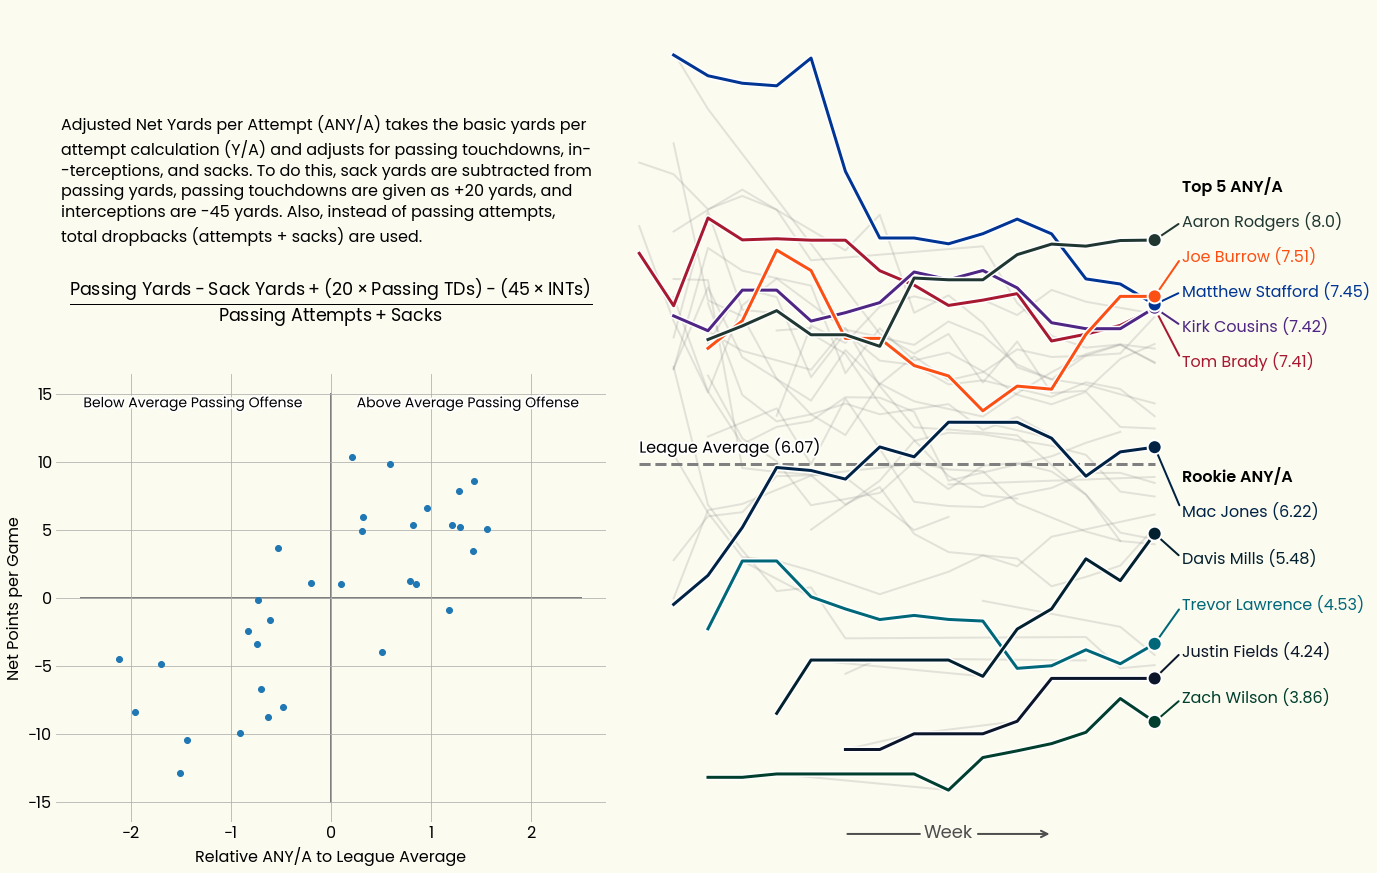

In [121]:
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

fig = plt.figure(figsize=(20, 15), facecolor="#fbfbf0")
gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0.02, wspace=0.03, height_ratios=[0.8, 1])
ax_formula = fig.add_subplot(gs[0, 0], frame_on=False)
ax_team_stats = fig.add_subplot(gs[1, 0], frame_on=False)
ax_league = fig.add_subplot(gs[:, 1], frame_on=False)

# Formula
ax_formula.text(
    0.01, 0.7,
    "Adjusted Net Yards per Attempt (ANY/A) takes the basic yards per \n" +
    "attempt calculation (Y/A) and adjusts for passing touchdowns, in-\n" +
    "-terceptions, and sacks. To do this, sack yards are subtracted from\n" +
    "passing yards, passing touchdowns are given as +20 yards, and \n" +
    "interceptions are -45 yards. Also, instead of passing attempts,\n" +
    "total dropbacks (attempts + sacks) are used.",
    ha="left",
    va="top",
    linespacing=1.4
)

ax_formula.text(
    0.5, 0.25,
    "$\mathregular{\\frac{Passing\;Yards - Sack\;Yards + (20 \\times Passing\;TDs) - (45 \\times INTs)}{Passing\;Attempts + Sacks}}$",
    ha="center",
    va="top",
    fontsize=25
)

ax_formula.set_xticks([])
ax_formula.set_yticks([])

# Performances
ax_team_stats.grid()
ax_team_stats.plot([-2.5, 2.5], [0, 0], color="gray", lw=2, zorder=1)
ax_team_stats.plot([0, 0], [-15, 15], color="gray", lw=2, zorder=1)
ax_team_stats.scatter(df_team_stats["any_a"] - league_avg.any_a, df_team_stats["net_pts"] / 17, zorder=2)
ax_team_stats.set_xlabel("Relative ANY/A to League Average", labelpad=5)
ax_team_stats.set_ylabel("Net Points per Game", labelpad=5)
ax_team_stats.text(
    0.75, 0.95,
    "Above Average Passing Offense",
    ha="center",
    va="top",
    size=14, 
    transform=ax_team_stats.transAxes,
    path_effects=[pe.withStroke(linewidth=4, foreground="white")]
)
ax_team_stats.text(
    0.25, 0.95,
    "Below Average Passing Offense",
    ha="center",
    va="top",
    size=14,
    transform=ax_team_stats.transAxes,
    path_effects=[pe.withStroke(linewidth=4, foreground="white")]
)

# League Average
ax_league.plot([3, 18], [league_avg.any_a, league_avg.any_a], linestyle="--", linewidth=3, color="gray", zorder=1)
ax_league.text(
    3, league_avg.any_a + 0.1, 
    f"League Average ({league_avg.any_a.round(2)})", 
    ha="left", 
    va="baseline",
    path_effects=[pe.withStroke(linewidth=4, foreground="white")]
)

# Dataframe to merge on all weeks and ffill
df_weeks = pd.DataFrame({"week": range(1, 19)})

# Plot Top 5 QBs
top_5_qbs = qb_list[:5]["full_name"]
midpoint_top_5 = (
    df_passing_cum[df_passing_cum["full_name"].isin(top_5_qbs)]
    .groupby("full_name", as_index=False)
    .apply(lambda grp: grp[grp["week"] == grp["week"].max()])["any_a"]
    .mean()
)
for i, qb in enumerate(top_5_qbs[::-1]):
    df_temp = (
        df_passing_cum[(df_passing_cum["full_name"] == qb) & (df_passing_cum["yards"] >= 1000)]
        .reset_index(drop=True)
        .merge(df_weeks, how="right")
        .ffill()
        .copy()
    )
    ax_league.plot(
        df_temp["week"], df_temp["any_a"], 
        color=qb_list[qb_list["full_name"] == qb].team_color.iloc[0], 
        linewidth=3, 
        markevery=[-1], 
        marker="o", 
        markersize=10, 
        markeredgewidth=2, 
        path_effects=[pe.withStroke(linewidth=6, foreground="white")],
        zorder=2
    )
    coords = (df_temp.iloc[-1].week, df_temp.iloc[-1].any_a)
    offset = (i - 2) * 0.3
    ax_league.annotate(
        f"{qb} ({df_temp.iloc[-1].any_a.round(2)})", 
        xy=coords, 
        xytext=(18.8, midpoint_top_5 + offset),
        color=qb_list[qb_list["full_name"] == qb].team_color.iloc[0],
        ha="left",
        va="center",
        arrowprops=dict(arrowstyle="-", relpos=(0, 0.5), linewidth=2, color=qb_list[qb_list["full_name"] == qb].team_color.iloc[0]),
        zorder=1
    )
    
ax_league.text(
    18.8, midpoint_top_5 + 0.9,
    "Top 5 ANY/A",
    ha="left",
    va="center",
    fontweight=600
)
    
# Plot rookie QBs
rookie_qbs = qb_list[qb_list["rookie"] == True]["full_name"]
midpoint_rookie = (
    df_passing_cum[df_passing_cum["full_name"].isin(rookie_qbs)]
    .groupby("full_name", as_index=False)
    .apply(lambda grp: grp[grp["week"] == grp["week"].max()])["any_a"]
    .mean()
)
for i, qb in enumerate(rookie_qbs[::-1]):
    df_temp = (
        df_passing_cum[(df_passing_cum["full_name"] == qb) & (df_passing_cum["yards"] >= 1000)]
        .reset_index(drop=True)
        .merge(df_weeks, how="right")
        .ffill()
        .copy()
    )
    ax_league.plot(
        df_temp["week"], df_temp["any_a"], 
        color=qb_list[qb_list["full_name"] == qb].team_color.iloc[0], 
        linewidth=3, 
        markevery=[-1], 
        marker="o", 
        markersize=10, 
        markeredgewidth=2, 
        path_effects=[pe.withStroke(linewidth=6, foreground="white")],
        zorder=2
    )
    coords = (df_temp.iloc[-1].week, df_temp.iloc[-1].any_a)
    offset = (i - 2) * 0.4
    ax_league.annotate(
        f"{qb} ({df_temp.iloc[-1].any_a.round(2)})", 
        xy=coords, 
        xytext=(18.8, midpoint_rookie + offset),
        color=qb_list[qb_list["full_name"] == qb].team_color.iloc[0],
        ha="left",
        va="center",
        arrowprops=dict(arrowstyle="-", relpos=(0, 0.5), linewidth=2, color=qb_list[qb_list["full_name"] == qb].team_color.iloc[0]),
        zorder=1
    )
    
ax_league.text(
    18.8, midpoint_rookie + 1.1,
    "Rookie ANY/A",
    ha="left",
    va="center",
    fontweight=600
)
    
# Plot rest of league in gray
for qb in qb_list["full_name"][5:]:
    df_temp = df_passing_cum[(df_passing_cum["full_name"] == qb) & (df_passing_cum["yards"] >= 1000)].copy()
    ax_league.plot(df_temp["week"], df_temp["any_a"], linewidth=2, color="gray", alpha=0.2, zorder=1)

ax_league.set_xticklabels([])
ax_league.set_xticks(range(3, 19))
ax_league.set_xlim(2.5, 18.5)
ax_league.annotate(
    "Week", 
    xy=(9, 2.9), xytext=(12, 2.9), 
    ha="center", va="center", 
    fontsize=18, 
    color="#4e4e4e",
    arrowprops=dict(arrowstyle="-", relpos=(0, 0.5), linewidth=2, color="#4e4e4e"), 
    annotation_clip=False
)
ax_league.annotate(
    "", 
    xy=(15, 2.9), xytext=(12.8, 2.9), 
    arrowprops=dict(arrowstyle="->", linewidth=2, color="#4e4e4e"), 
    annotation_clip=False
)

ax_league.set_yticklabels([])
ax_league.set_ylim(3, 10)
#plt.savefig("any_a.png", dpi=300, bbox_inches="tight")
plt.show()